## Sentiment Analysis with NLP

### Overview

Apple and Google are two leading technology companies with a vast presence in the consumer electronics and software markets. Both companies recently launched new products: Apple introduced the iPhone 15, while Google unveiled the Pixel 8. To understand consumer perceptions and brand positioning, both companies want to conduct sentiment analysis on social media to gauge public reactions to these launches.

### Objectives:

1. Develop a specialized sentiment analysis model to evaluate Twitter sentiments regarding Apple and Google products.
2. Identify specific emotions associated with each brand’s products.
3. Analyze customer feedback to inform future product development and marketing strategies.

## NLP Procedures
**1. Data Collection:**
Use Twitter's API to gather tweets mentioning "iPhone 15," "Pixel 8," "Apple," and "Google," as well as relevant hashtags like #iPhone15 and #Pixel8.

Focus on tweets from the product launch period and a few weeks following to capture initial reactions.

**2. Preprocessing:**

. Text Cleaning: Remove URLs, mentions (@username), hashtags, and special characters from the tweet text.

. Tokenization: Split the cleaned text into individual words or tokens.

. Lowercasing: Convert all tokens to lowercase to maintain uniformity.

. Stopword Removal: Remove common stopwords (e.g., "and," "the," "is") that do not contribute to sentiment.

**3. Sentiment Analysis:**

. Use a pre-trained sentiment analysis model (like VADER or a fine-tuned BERT model) to classify each tweet as positive, negative, or neutral.

. Extract and categorize the emotions (e.g., joy, anger, surprise) expressed in tweets using an emotion detection model.

**4. Feature Extraction:**

. Use techniques like TF-IDF or word embeddings (e.g., Word2Vec or GloVe) to represent tweet text as numerical features for further analysis.

**5. Analysis:**

. Aggregate Sentiment Scores: Calculate the overall sentiment score and categorize tweets by positive, negative, and neutral sentiment.

. Emotion Analysis: Identify and compare the frequency of emotions associated with each brand, such as joy for Apple and trust for Google.

**6. Visualization:**

. Create visual representations (like bar charts or word clouds) to illustrate overall sentiment, emotion distribution, and trends over time.

**7. Reporting:**

. Prepare a report summarizing findings, including key sentiments, emotional trends, and actionable insights for the marketing team. Recommendations could include addressing negative sentiment themes or amplifying positive feedback in future campaigns.

. Through this sentiment analysis, EcoTech can gain valuable insights into customer perceptions of their new product line, allowing them to make informed decisions to enhance their marketing strategy and improve overall brand reputation.

### Task
Build a model that can rate the sentiment of a Tweet based on its content.

## DATA UNDERSTANDING
Let us first import all the relevant modules and load the dataset.

In [357]:
# Importing th relevant libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
import os

In [358]:
import re
import nltk
import string
from nltk import FreqDist
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# import spacy
# # nlp = spacy.load("en_core_web_sm")

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [359]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm

In [360]:
# Check GPU status
# if tf.test.gpu_device_name(): 
#     print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
# else:
#     print("Please install GPU version of TF")

In [361]:
# Downloading nltk metrics
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/madservices/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/madservices/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/madservices/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Load the Data

In [362]:
# Loading the dataset
df = pd.read_csv("data/judge-1377884607_tweet_product_company.csv", encoding='unicode_escape')

# Checking the dataset
df.head()
# print()
# print(df.describe())

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [363]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


The dataset for this project, sourced from https://data.world/crowdflower/brands-and-product-emotions is well-suited for our objectives. This rich resource, which comprises of three columns and 9,093 rows, is ideal for training and testing our sentiment analysis models, effectively capturing real-world sentiment from a platform where users openly share their opinions.

### Column Description
*  tweet_text: The text of the tweets.
*  emotion_in_tweet_is_directed_at: Insights into the emotions expressed.
*  is_there_an_emotion_directed_at_a_brand_or_product: Indicates the specific brand or product related to the emotion.

With its sizable sample, the dataset provides ample data for model training and validation. The features have been carefully selected for their relevance, particularly focusing on the tweet text and the emotions associated with brands or products, which are crucial for understanding sentiment dynamics.

However, the dataset does have limitations. Interpreting tweet sentiment can be complex due to contextual factors and sarcasm. Additionally, it may not fully represent all sentiments expressed on Twitter, potentially impacting the comprehensiveness of our analysis.

## DATA CLEANING
Ok first let us rename the columns and check if there are any missing, null, or duplicate values in our dataset.

In [364]:
# Renaming the columns for ease of access
df.rename(columns={
    'tweet_text': 'Tweet',
    'emotion_in_tweet_is_directed_at': 'Product',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'Sentiment'
}, inplace=True)

In [365]:
# Checking the data
df.head()

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [366]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      9092 non-null   object
 1   Product    3291 non-null   object
 2   Sentiment  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


Obviously as we can see it, we have a single missing value in the Tweet column and more than 5k values missing from the Product column. Since the product column is very crucial to our analysis we will fill the missing values with placeholder values while dropping the single missing row from the Tweet column.


In [367]:
# Dropping a row from the Tweet column
df.dropna(subset=['Tweet'], inplace=True)

# Filling the missing values in the Product column with placeholder values
df['Product'].fillna('Unknown Product', inplace=True)

# Checking the data
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      9092 non-null   object
 1   Product    9092 non-null   object
 2   Sentiment  9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


/var/folders/m7/31mld3hn46s_y1f05nhxt1_c0000gn/T/ipykernel_1478/1983182332.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Product'].fillna('Unknown Product', inplace=True)


In [368]:
# Checking for duplicates
df.duplicated().sum()

22

We have here 22 duplicate values in the dataset which we need to deeply check incase they are same values from different tweets. If so then we will keep them otherwise we will drop them and continue processing the dataset.

In [369]:
# Investigating the duplicates
duplicates = df[df.duplicated()]
duplicates

,Tweet,Product,Sentiment
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
776,Google to Launch Major New Social Network Call...,Unknown Product,No emotion toward brand or product
2232,Marissa Mayer: Google Will Connect the Digital...,Unknown Product,No emotion toward brand or product
2559,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
3950,Really enjoying the changes in Gowalla 3.0 for...,Android App,Positive emotion
3962,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
4897,"Oh. My. God. The #SXSW app for iPad is pure, u...",iPad or iPhone App,Positive emotion
5338,RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ...,Unknown Product,No emotion toward brand or product
5341,"RT @mention ÷¼ Happy Woman's Day! Make love, ...",Unknown Product,No emotion toward brand or product
5881,RT @mention Google to Launch Major New Social ...,Unknown Product,No emotion toward brand or product


In [370]:
# Dropping duplicates
df.drop_duplicates(subset='Sentiment', keep='first')

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,Unknown Product,No emotion toward brand or product
90,Thanks to @mention for publishing the news of ...,Unknown Product,I can't tell


Let us visualize the sentiments values to get a better understanding.

In [371]:
# Running a sentiment count
sentiment_counts = df['Sentiment'].value_counts()
sentiment_counts

Sentiment
No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

Text(0, 0.5, 'Count')

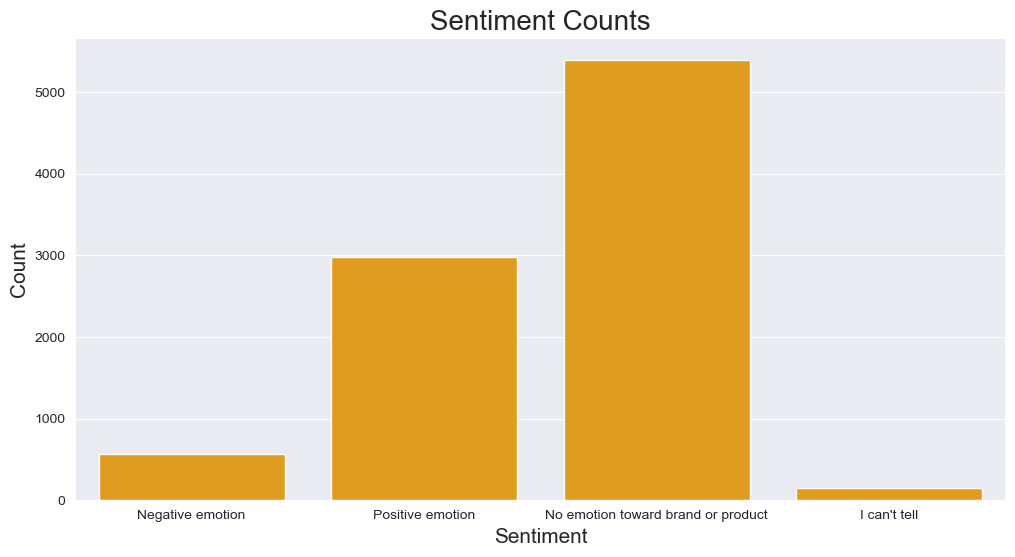

In [372]:
# Plotting the sentiments
fig =  plt.figure(figsize=(12,6))
sns.countplot(x='Sentiment', data=df, color = 'orange')
plt.title('Sentiment Counts', size=20)
plt.xlabel('Sentiment', size=15)
plt.ylabel('Count', size=15)


There are altogether four sentiment classes in which neutral type of emotion ('No emotion...') is more prevalent. We can also see the sentiment 'I can't tell' constitutes only tiny portion of the data. Sentiment wise, this might be closer to the neutral type in which case we could combine with the neutral class. However, this class is already a majority class which is already causing huge imbalance in the dataset. So, we will drop the data with this class label.

In [373]:
# Dropping the 'I can't tell' class label
df = df[(df['Sentiment']!= "I can't tell")]

# Renaming the 'No emotion toward brand or product" to 'Neutral'
df['Sentiment'].replace('No emotion toward brand or product', 'Neutral')

# Encoding class label to brief
label_encoder = {'Negative emotion': 'negative',
                 'Positive emotion': 'positive',
                 'No emotion toward brand or product': 'neutral',
                 "I can't tell":'confused'}

df['Sentiment'] = df['Sentiment'].map(label_encoder)

# Running sentiment count again
sentiment_counts = df['Sentiment'].value_counts()
sentiment_counts

Sentiment
neutral     5388
positive    2978
negative     570
Name: count, dtype: int64

Let us check the Product column in the dataset

In [374]:
# Running product count
product_counts = df['Product'].value_counts()
product_counts

Product
Unknown Product                    5654
iPad                                942
Apple                               659
iPad or iPhone App                  470
Google                              429
iPhone                              296
Other Google product or service     292
Android App                          81
Android                              78
Other Apple product or service       35
Name: count, dtype: int64

Text(0, 0.5, 'Product')

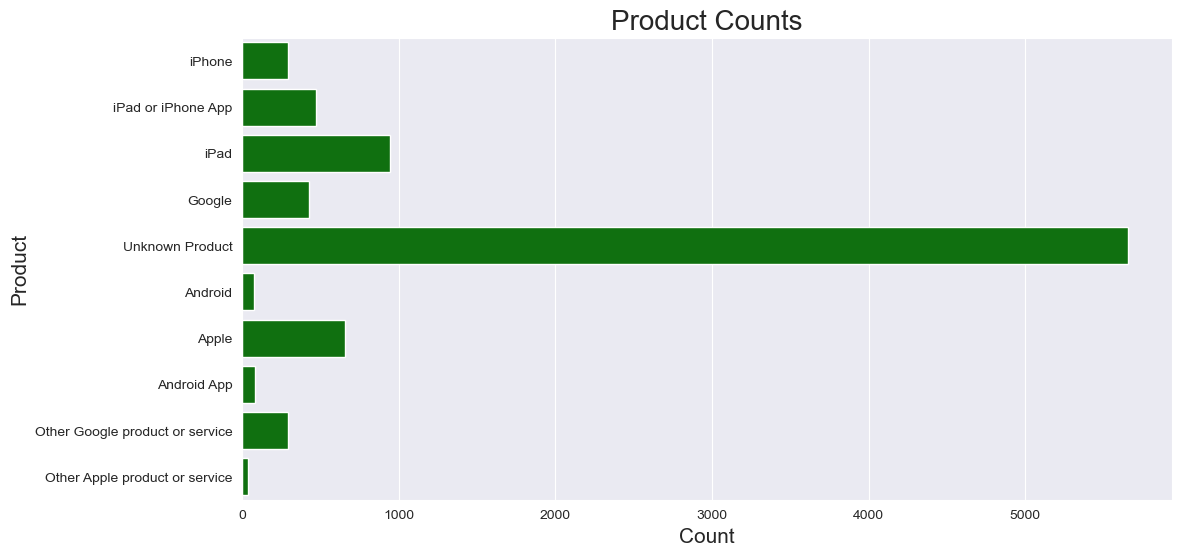

In [375]:
# Plotting product counts
fig =  plt.figure(figsize=(12,6))
sns.countplot(y='Product', data=df, color = 'green')
plt.title('Product Counts', size=20)
plt.xlabel('Count', size=15)
plt.ylabel('Product', size=15)

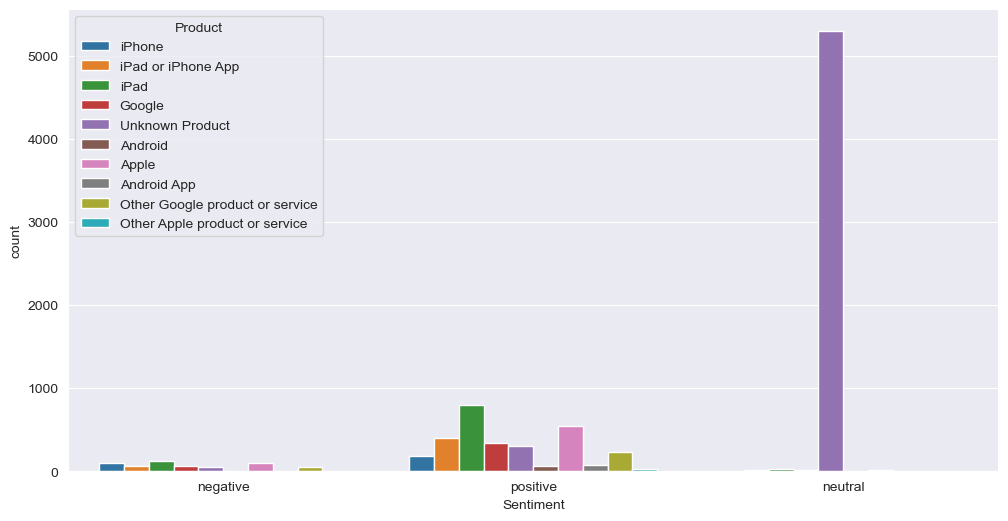

In [382]:
# Plotting sentiment count for each product
plt.figure(figsize=(12,6))
ax = sns.countplot(data=df, x = 'Sentiment', hue='Product')

The product column is divided into 10 classes which can be categorized into 2; Apple and Google basically with the exception of the unknown class. That is what we will be doing in the next cell below.

In [376]:
# Creating a copy of the dataframe
df_clean = df.copy()

In [377]:
# Brand name mapping
brand = {'iPhone': 'Apple',
         'iPad or iPhone App':'Apple',
         'iPad': 'Apple',
         'Google': 'Google',
         'Unknown Product': 'Unknown',
         'Android':'Google',
         'Apple': 'Apple',
         'Android App':'Google',
         'Other Google product or service':'Google',
         'Other Apple product or service':'Apple'
        }

# Applying the mapping
df_clean['Product'] = df_clean['Product'].map(brand)
df_clean['Product'].value_counts()

Product
Unknown    5654
Apple      2402
Google      880
Name: count, dtype: int64

Text(0, 0.5, 'Count')

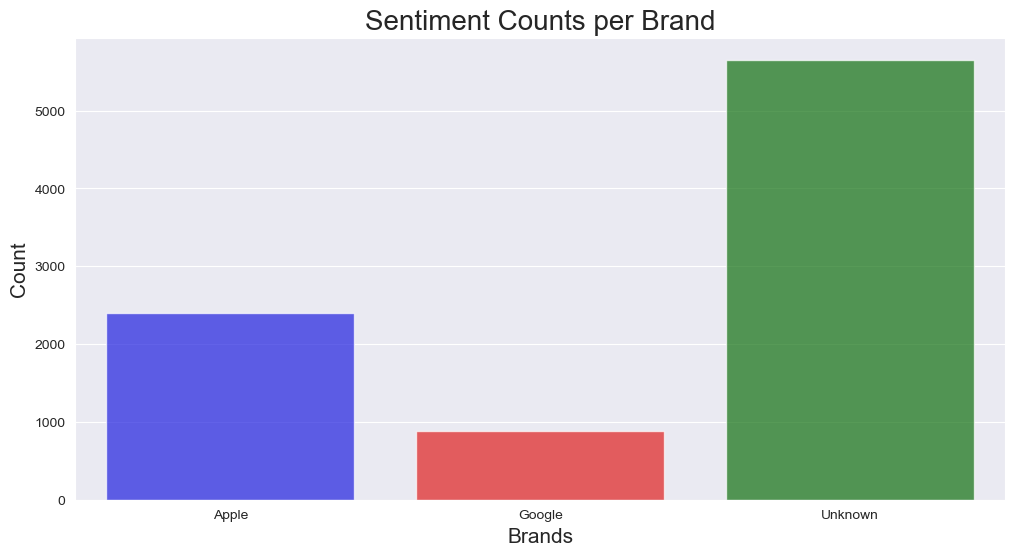

In [379]:
# Plotting the mapped brands
fig =  plt.figure(figsize=(12,6))
sns.countplot(x='Product', data=df_clean, hue='Product', palette={'Apple':'b', 'Google':'r', 'Unknown':'g'}, alpha=0.7)
plt.title('Sentiment Counts per Brand', size=20)
plt.xlabel('Brands', size=15)
plt.ylabel('Count', size=15)

Now, let's proceed with the text preprocessing steps. We will:

1. Remove URLs
2. Remove punctuation
3. Convert all text to lowercase
4. Remove stopwords
5. Apply stemming and lemmatization

We will also create a function to perform these steps.

Text(0, 0.5, 'Count')

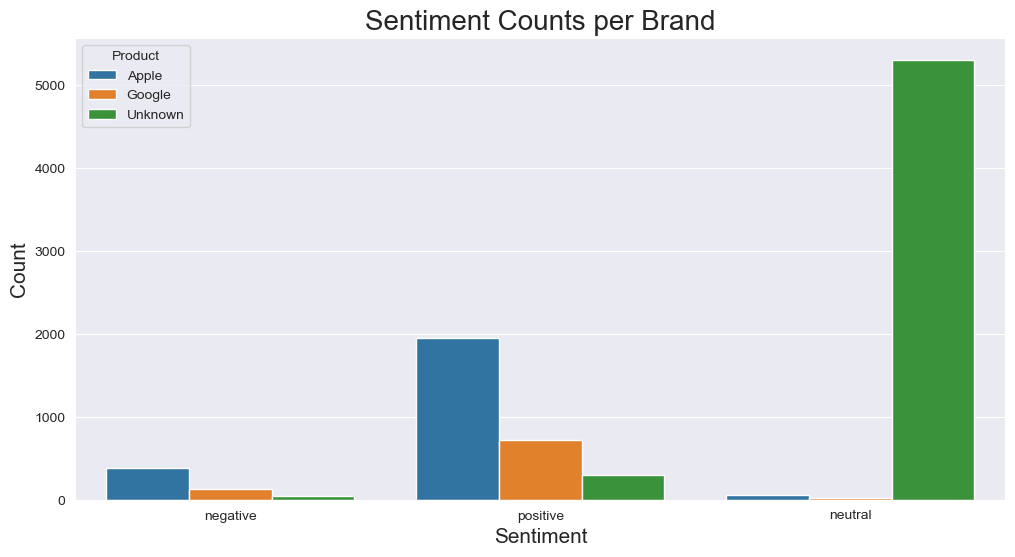

In [388]:
# Plotting the sentiment counts and comparing them against each other
plt.figure(figsize=(12,6))
ax = sns.countplot(data=df_clean, x = 'Sentiment', hue='Product')
plt.title('Sentiment Counts per Brand', size=20)
plt.xlabel('Sentiment', size=15)
plt.ylabel('Count', size=15)